Tutorials for course ECE1508 Reinforcement Learning at the University of Toronto.

Author: Xiaocan (Bruce) Li

Email: hsiaotsan.li@mail.utoronto.ca

#Overview

In this tutorial, we are going to solve Mountain Car game that has a continuous state space, and a discrete action space.

**About The Mountain Car**:

It's MDP is a deterministic MDP that consists of a car placed randomly at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to accelerate the car to reach the goal state on top of the right hill.

Two ways to deal with the continuous state space:
1. **Discretization [Covered This Week at June 26]**: Uniformly cut each state variable into bins, and then solve it with **Tabular RL**, e.g., Q-learning, SARSA.
2. **Linear Function Approximation [Covered Next Week at July 3]**: To represent the Q-function, we replace the Q-table, which traditionally maps state-action pairs to values, with a linear model. Instead of storing and updating a table of Q-values, we maintain a set of model weights. These weights are used together with features derived from the state-action pairs to estimate Q-values.



**Space Complexity of Discretization:**

For the Mountain Car, the original state is 2D: [position, velocity].

Discretize each state variable into $b$ bins resulting in $b^2$ possible combination of discretized state variables.

**Quiz**:

What is the space complexity if we have $|S|$ state variables and $b$ bins for each state variable? If we double $b$, how many extra spaces are needed?


**Related links:**
* Mountain Car Official Website: https://www.gymlibrary.dev/environments/classic_control/mountain_car/
* Mountain Car Source Code: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
* OpenAI Leaderboard for Mountain Car: https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0

# Install libraries

In [ ]:
!pip install gym==0.25.2
!pip install numpy==1.25.2
!pip install matplotlib==3.7.1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Import libraries

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pickle
from tqdm import tqdm

# Part 1: Q-Learning and SARSA with Discretized State Space

## Define helper functions and learning algorithms

In [ ]:
np.linspace(-1.2, 0.6, 4+1)

array([-1.2 , -0.75, -0.3 ,  0.15,  0.6 ])

In [ ]:
np.linspace(-1.2, 0.6, 4+1)[1:-1]

array([-0.75, -0.3 ,  0.15])

In [ ]:
np.digitize(-1.1, [-0.75, -0.3 ,  0.15])

0

In [ ]:
def discretize_state_space(env, bins):
    # Discretize the state space into bins per state dimension
    obs_space = env.observation_space
    env_low = obs_space.low
    env_high = obs_space.high
    env_bins = [np.linspace(env_low[i], env_high[i], bins + 1)[1:-1] for i in range(len(env_low))]
    return env_bins


def get_state(state, bin_values):
    # Convert continuous state into a discrete state
    indices = []
    for i in range(len(state)):
        indices.append(np.digitize(state[i], bin_values[i]) - 1)
    return tuple(indices)


def q_learning(env, n_episodes, alpha, gamma, epsilon, bins):
    # Q-Learning Algorithm
    Q = np.zeros((bins, bins, env.action_space.n))
    env_bins = discretize_state_space(env, bins)
    episode_rewards = np.zeros(n_episodes) # Replace the zero vector with what you computed in the loop

    for episode in tqdm(range(n_episodes), desc="Training Progress"):
        done = False
        episode_reward = 0

        state = get_state(env.reset(), env_bins)

        while not done:
            # Epsilon-greedy policy
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state_raw, reward, done, _ = env.step(action)
            episode_reward += reward
            next_state = get_state(next_state_raw, env_bins)

            # Update Q-Table
            best_next_action = np.argmax(Q[next_state])
            Q[state + (action,)] += alpha * (reward + gamma * Q[next_state + (best_next_action,)] - Q[state + (action,)])

            state = next_state

        episode_rewards[episode] = episode_reward


    avg_reward_array = np.cumsum(episode_rewards) / (np.arange(n_episodes) + 1)
    plt.plot([k+1 for k in range(n_episodes)], avg_reward_array, color='black', linewidth=0.5)
    plt.ylabel('Average Reward', fontsize=12)
    plt.xlabel('Episode', fontsize=12)
    plt.title(f'Learning by Q-Learning for {n_episodes} Episodes', fontsize=12)
    plt.show()

    return Q, avg_reward_array


def sarsa(env, n_episodes, alpha, gamma, epsilon, bins):
    # SARSA Algorithm
    Q = np.zeros((bins, bins, env.action_space.n))
    env_bins = discretize_state_space(env, bins)
    episode_rewards = np.zeros(n_episodes) # Replace the zero vector with what you computed in the loop

    for episode in tqdm(range(n_episodes), desc="Training Progress"):
        done = False
        episode_reward = 0

        state = get_state(env.reset(), env_bins)

        if (episode+1) % 1000 == 0:
            epsilon *= 0.5
            print(f"Now at Episode {episode+1}. Epsilon = {epsilon}")

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        while not done:
            next_state_raw, reward, done, _ = env.step(action)
            episode_reward += reward
            next_state = get_state(next_state_raw, env_bins)

            if np.random.random() < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q[next_state])

            # Update Q-Table
            Q[state + (action,)] += alpha * (reward + gamma * Q[next_state + (next_action,)] - Q[state + (action,)])

            state, action = next_state, next_action

        episode_rewards[episode] = episode_reward


    avg_reward_array = np.cumsum(episode_rewards) / (np.arange(n_episodes) + 1)
    plt.plot([k+1 for k in range(n_episodes)], avg_reward_array, color='black', linewidth=0.5)
    plt.ylabel('Average Reward', fontsize=12)
    plt.xlabel('Episode', fontsize=12)
    plt.title(f'Learning by SARSA for {n_episodes} Episodes', fontsize=12)
    plt.show()

    return Q, avg_reward_array


def evaluate_policy(env, Q, bins, n_episodes=1, render=False):
    env_bins = discretize_state_space(env, bins)
    total_rewards = []

    for _ in tqdm(range(n_episodes), desc="Evaluation Progress"):
        done = False
        total_reward = 0
        state = get_state(env.reset(), env_bins)

        while not done:
            action = np.argmax(Q[state])  # Choose the best action from Q-table
            next_state_raw, reward, done, _ = env.step(action)
            if render:
                env.render()  # Render the step
            next_state = get_state(next_state_raw, env_bins)

            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)
        # print(f"Episode finished with total reward: {total_reward}")

    env.close()
    print(f"Average reward over {n_episodes} episodes: {np.mean(total_rewards)}")
    return np.mean(total_rewards), np.std(total_rewards)


def plot_policy_for_tabular_q_for_mountain_car(env, bins, Q):
    obs_space = env.observation_space
    env_low = obs_space.low
    env_high = obs_space.high

    # Discretize each dimension of the state space into 'bins' number of bins
    position_bins = np.linspace(env_low[0], env_high[0], bins)
    velocity_bins = np.linspace(env_low[1], env_high[1], bins)

    # Create a plot
    fig, ax = plt.subplots()

    policy = np.argmax(Q, axis=2)
    cax = ax.imshow(policy, cmap="viridis", origin="lower", aspect='auto')

    # Create colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Action')

    # Set labels
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')

    # Define tick marks in terms of bin indices
    position_ticks = np.arange(bins)
    velocity_ticks = np.arange(bins)

    # Convert tick marks to original state space values
    position_labels = ["{:.2f}".format(p) for p in position_bins]
    velocity_labels = ["{:.2f}".format(v) for v in velocity_bins]

    # Apply the ticks to the plot
    ax.set_xticks(position_ticks)
    ax.set_xticklabels(position_labels)
    ax.set_yticks(velocity_ticks)
    ax.set_yticklabels(velocity_labels)

    # Rotate the position labels for better readability
    plt.xticks(rotation=45)

    plt.show()

In [ ]:
# Load files from google drive
# Only run this code if you run this notebook on *Google Colab* to save your training results.
# You can skip this code block if you run elsewhere.
if False:
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Projects/ECE1508_RL')
  !ls

Mounted at /content/drive
Q_learning_mountain_car_v0_avg_training_reward_vs_episode.png
Q_learning_mountain_car_v0.pkl
Q_SARSA_mountain_car_v0_avg_training_reward_vs_episode.png
Q_SARSA_mountain_car_v0.pkl


## Q-Learning

### Training

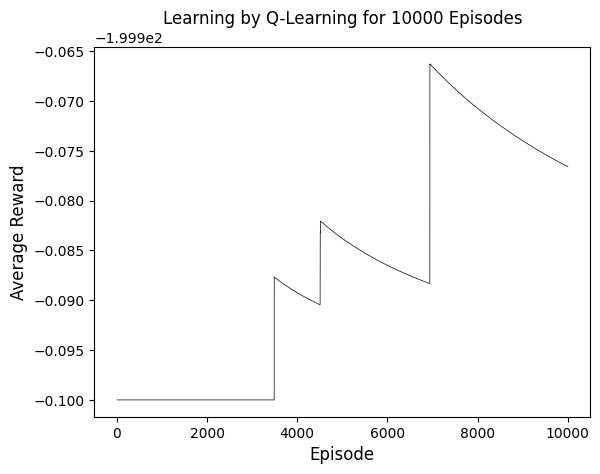

Time taken for 2 bins: 117.21970248222351


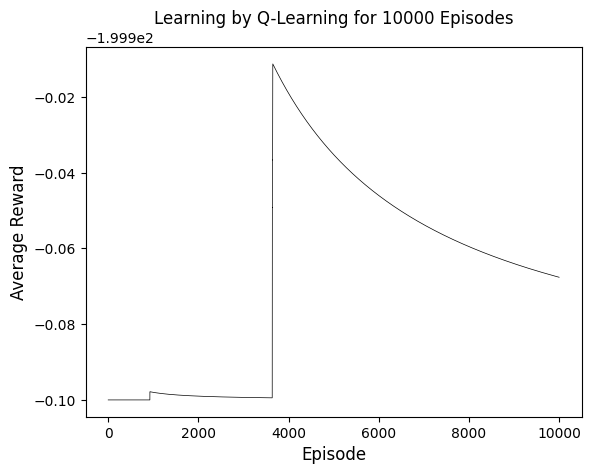

Time taken for 4 bins: 120.4491240978241


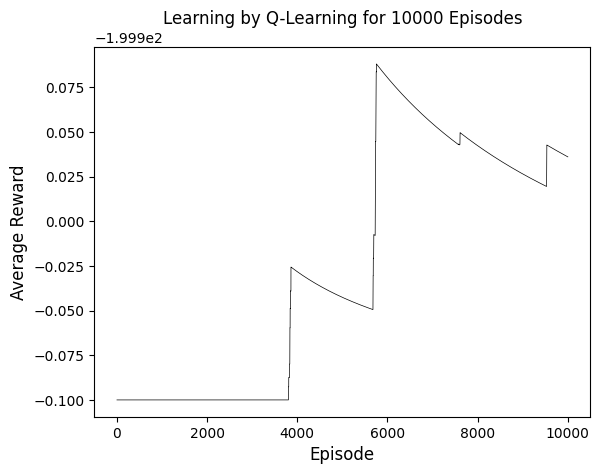

Time taken for 8 bins: 118.41215586662292


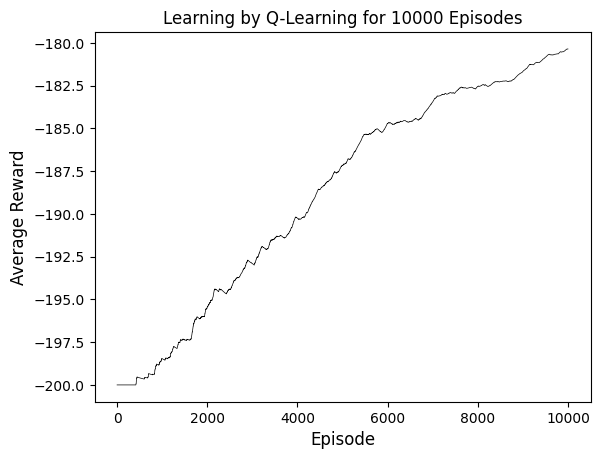

Time taken for 16 bins: 105.78485894203186


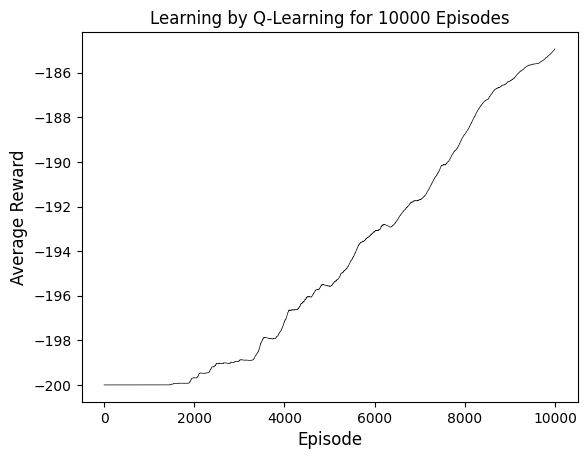

Time taken for 32 bins: 127.57304072380066


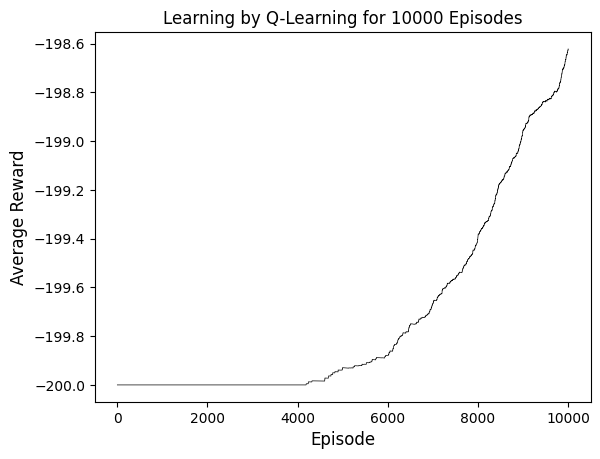

Time taken for 64 bins: 125.11214089393616


In [ ]:
# Initialize the environment
env = gym.make('MountainCar-v0')

# Initialize storage
Q_ql_dict = {}


# Parameters
episodes = 10000
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# Record parameters
Q_ql_dict['params'] = {'alpha': alpha,
            'gamma': gamma,
            'epsilon': epsilon,
            'episodes': episodes,
            }


for bins in [2, 4, 8, 16, 32, 64]:
    start_time = time()
    Q_ql, avg_reward_array = q_learning(env, episodes, alpha, gamma, epsilon, bins)
    end_time = time()

    print(f"Time taken for {bins} bins: {end_time - start_time}")
    Q_ql_dict[bins] = {'Q_table': Q_ql,
                       'training_duration': end_time - start_time,
                       'training_rewards': avg_reward_array,
                       }





with open(f'./Q_learning_mountain_car_v0_episodes={episodes}_alpha={alpha}_gamma={gamma}_eps={epsilon}.pkl', 'wb') as f:
    pickle.dump(Q_ql_dict, f)

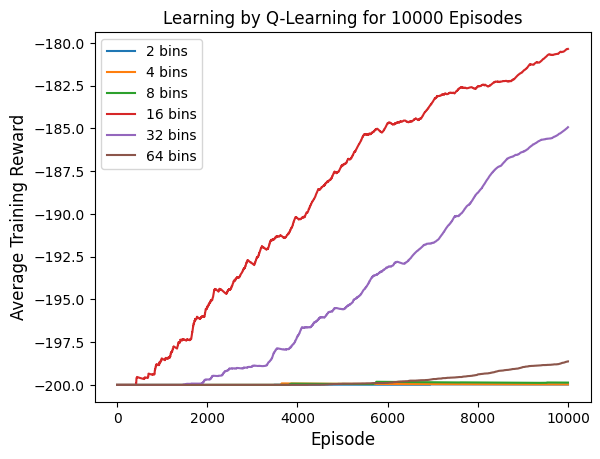

In [ ]:
# Plot training rewards vs episode index for each bins number
for bins in [2, 4, 8, 16, 32, 64]:
    plt.plot([k+1 for k in range(episodes)], Q_ql_dict[bins]['training_rewards'], label=f'{bins} bins')
plt.ylabel('Average Training Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.title(f'Learning by Q-Learning for {episodes} Episodes', fontsize=12)
plt.legend()
plt.savefig('./Q_learning_mountain_car_v0_avg_training_reward_vs_episode.png')
plt.show()

Out of curiosity, for bins=16, how many episodes are required to achieve convergence of performance? The following code block try to train with 50000 episodes.

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Training Progress:   0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Training Progress: 100%|██████████| 50000/50000 [08:53<00:00, 93.76it/s]


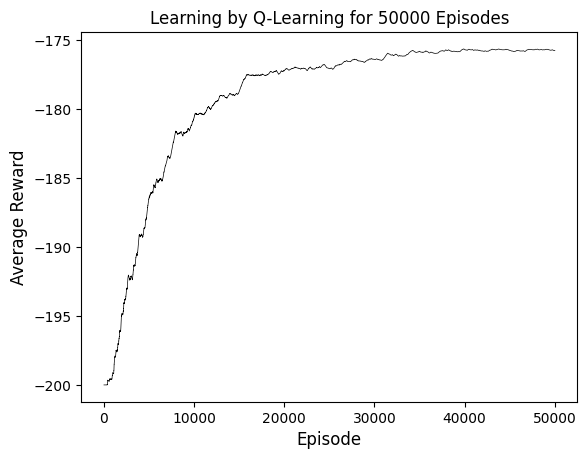

Time taken for 16 bins: 533.5516519546509


In [ ]:
# Initialize the environment
env = gym.make('MountainCar-v0')

# Initialize storage
Q_ql_dict = {}


# Parameters
episodes = 50000
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# Record parameters
Q_ql_dict['params'] = {'alpha': alpha,
            'gamma': gamma,
            'epsilon': epsilon,
            'episodes': episodes,
          }


for bins in [16]:
    start_time = time()
    Q_ql, avg_reward_array = q_learning(env, episodes, alpha, gamma, epsilon, bins)
    end_time = time()

    print(f"Time taken for {bins} bins: {end_time - start_time}")
    Q_ql_dict[bins] = {'Q_table': Q_ql,
                       'training_duration': end_time - start_time,
                       'training_rewards': avg_reward_array,
                       }





with open(f'./Q_learning_mountain_car_v0_episodes={episodes}_alpha={alpha}_gamma={gamma}_eps={epsilon}.pkl', 'wb') as f:
    pickle.dump(Q_ql_dict, f)

In [ ]:
evaluate_policy(env, Q_ql_dict[bins]['Q_table'], bins, n_episodes=100, render=False)

Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 142.56it/s]

Average reward over 50000 episodes: -162.67


(-162.67, 25.671016730936078)

### Evaluation

In [ ]:
with open('Q_learning_mountain_car_v0.pkl', 'rb') as f:
    Q_ql_dict = pickle.load(f)

bins = 16
env = gym.make('MountainCar-v0')


evaluate_policy(env, Q_ql_dict[bins]['Q_table'], bins, n_episodes=1, render=False)

Training Progress: 100%|██████████| 100/100 [00:02<00:00, 34.42it/s]


Average reward over 10000 episodes: -200.0


Training Progress: 100%|██████████| 100/100 [00:00<00:00, 107.90it/s]


Average reward over 10000 episodes: -200.0


Training Progress: 100%|██████████| 100/100 [00:00<00:00, 106.25it/s]


Average reward over 10000 episodes: -196.05


Training Progress: 100%|██████████| 100/100 [00:00<00:00, 141.98it/s]


Average reward over 10000 episodes: -147.32


Training Progress: 100%|██████████| 100/100 [00:00<00:00, 108.33it/s]


Average reward over 10000 episodes: -167.31


Training Progress: 100%|██████████| 100/100 [00:01<00:00, 77.90it/s]


Average reward over 10000 episodes: -182.61


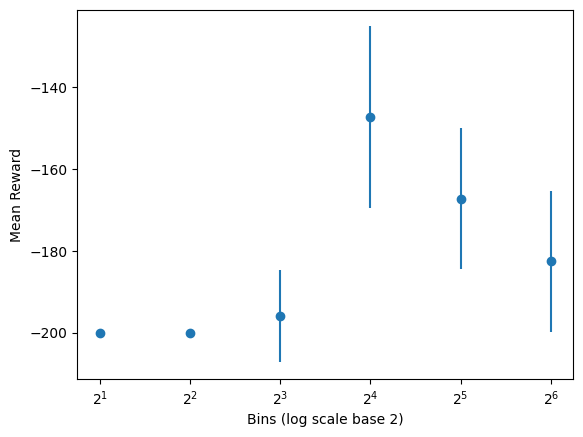

In [ ]:
# Evaluate for each bins
# Store mean and std of rewards
mean_reward_list = []
std_reward_list = []

for bins in [2, 4, 8, 16, 32, 64]:
    mean_reward, std_reward = evaluate_policy(env, Q_ql_dict[bins]['Q_table'], bins, n_episodes=100)
    mean_reward_list.append(mean_reward)
    std_reward_list.append(std_reward)

# Plot mean reward with std vs bins
plt.errorbar([2, 4, 8, 16, 32, 64], mean_reward_list, yerr=std_reward_list, fmt='o')
plt.xscale('log', base=2)
plt.xlabel('Bins (log scale base 2)')
plt.ylabel('Mean Reward')
# plt.title('Error Bar Plot with Log Scale X-axis')
plt.show()

### Policy Visualization

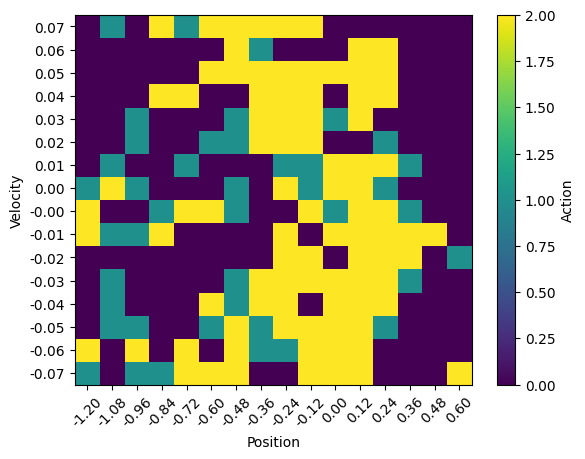

In [ ]:
plot_policy_for_tabular_q_for_mountain_car(env, bins=16, Q=Q_ql_dict[16]['Q_table'])

## SARSA

### Training

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Training Progress:   0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Training Progress:  10%|█         | 1009/10000 [00:12<01:40, 89.90it/s]

Now at Episode 1000. Epsilon = 0.25


Training Progress:  20%|██        | 2003/10000 [00:31<02:06, 63.14it/s]

Now at Episode 2000. Epsilon = 0.125


Training Progress:  30%|███       | 3017/10000 [00:46<01:20, 86.42it/s]

Now at Episode 3000. Epsilon = 0.0625


Training Progress:  40%|████      | 4018/10000 [01:01<01:05, 91.83it/s]

Now at Episode 4000. Epsilon = 0.03125


Training Progress:  50%|█████     | 5006/10000 [01:17<01:51, 44.92it/s]

Now at Episode 5000. Epsilon = 0.015625


Training Progress:  60%|██████    | 6011/10000 [01:35<01:01, 64.97it/s]

Now at Episode 6000. Epsilon = 0.0078125


Training Progress:  70%|███████   | 7014/10000 [01:47<00:33, 89.98it/s]

Now at Episode 7000. Epsilon = 0.00390625


Training Progress:  80%|████████  | 8014/10000 [02:00<00:22, 86.99it/s]

Now at Episode 8000. Epsilon = 0.001953125


Training Progress:  90%|█████████ | 9015/10000 [02:12<00:11, 82.25it/s]

Now at Episode 9000. Epsilon = 0.0009765625


Training Progress: 100%|██████████| 10000/10000 [02:28<00:00, 67.50it/s]


Now at Episode 10000. Epsilon = 0.00048828125


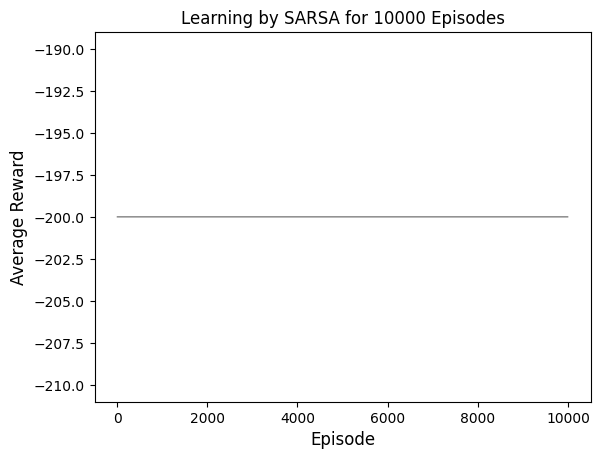

Time taken for 2 bins: 148.45771169662476


Training Progress:  10%|█         | 1019/10000 [00:13<01:34, 94.69it/s]

Now at Episode 1000. Epsilon = 0.25


Training Progress:  20%|██        | 2006/10000 [00:25<02:21, 56.64it/s]

Now at Episode 2000. Epsilon = 0.125


Training Progress:  30%|███       | 3008/10000 [00:37<01:53, 61.70it/s]

Now at Episode 3000. Epsilon = 0.0625


Training Progress:  40%|████      | 4011/10000 [00:49<01:06, 90.13it/s]

Now at Episode 4000. Epsilon = 0.03125


Training Progress:  50%|█████     | 5010/10000 [01:02<00:53, 92.88it/s]

Now at Episode 5000. Epsilon = 0.015625


Training Progress:  60%|██████    | 6018/10000 [01:15<00:40, 98.76it/s]

Now at Episode 6000. Epsilon = 0.0078125


Training Progress:  70%|███████   | 7013/10000 [01:27<00:34, 85.96it/s]

Now at Episode 7000. Epsilon = 0.00390625


Training Progress:  80%|████████  | 8017/10000 [01:40<00:22, 86.22it/s]

Now at Episode 8000. Epsilon = 0.001953125


Training Progress:  90%|█████████ | 9008/10000 [01:51<00:15, 63.83it/s]

Now at Episode 9000. Epsilon = 0.0009765625


Training Progress: 100%|██████████| 10000/10000 [02:03<00:00, 80.84it/s]


Now at Episode 10000. Epsilon = 0.00048828125


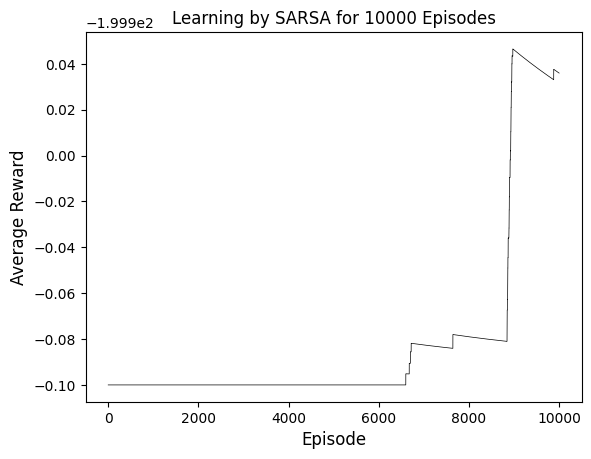

Time taken for 4 bins: 123.98042321205139


Training Progress:  10%|█         | 1019/10000 [00:13<01:38, 91.34it/s]

Now at Episode 1000. Epsilon = 0.25


Training Progress:  20%|██        | 2010/10000 [00:26<01:25, 93.72it/s]

Now at Episode 2000. Epsilon = 0.125


Training Progress:  30%|███       | 3011/10000 [00:39<01:45, 65.99it/s]

Now at Episode 3000. Epsilon = 0.0625


Training Progress:  40%|████      | 4005/10000 [00:53<01:03, 94.43it/s]

Now at Episode 4000. Epsilon = 0.03125


Training Progress:  50%|█████     | 5018/10000 [01:06<00:58, 85.22it/s]

Now at Episode 5000. Epsilon = 0.015625


Training Progress:  60%|██████    | 6006/10000 [01:18<01:17, 51.42it/s]

Now at Episode 6000. Epsilon = 0.0078125


Training Progress:  70%|███████   | 7010/10000 [01:29<00:24, 121.12it/s]

Now at Episode 7000. Epsilon = 0.00390625


Training Progress:  80%|████████  | 8016/10000 [01:41<00:18, 106.46it/s]

Now at Episode 8000. Epsilon = 0.001953125


Training Progress:  90%|█████████ | 9010/10000 [01:53<00:10, 90.85it/s]

Now at Episode 9000. Epsilon = 0.0009765625


Training Progress: 100%|██████████| 10000/10000 [02:06<00:00, 79.19it/s]


Now at Episode 10000. Epsilon = 0.00048828125


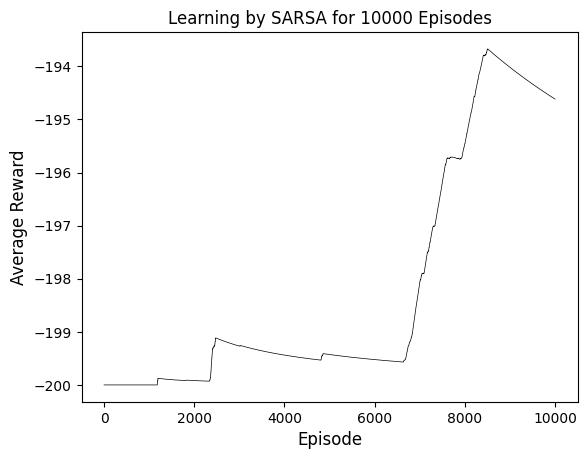

Time taken for 8 bins: 126.55191326141357


Training Progress:  10%|█         | 1009/10000 [00:12<02:30, 59.82it/s]

Now at Episode 1000. Epsilon = 0.25


Training Progress:  20%|██        | 2007/10000 [00:24<01:59, 66.70it/s]

Now at Episode 2000. Epsilon = 0.125


Training Progress:  30%|███       | 3014/10000 [00:36<01:12, 96.17it/s]

Now at Episode 3000. Epsilon = 0.0625


Training Progress:  40%|████      | 4021/10000 [00:47<01:01, 97.61it/s]

Now at Episode 4000. Epsilon = 0.03125


Training Progress:  50%|█████     | 5009/10000 [00:56<00:57, 86.27it/s]

Now at Episode 5000. Epsilon = 0.015625


Training Progress:  60%|██████    | 6019/10000 [01:05<00:35, 113.33it/s]

Now at Episode 6000. Epsilon = 0.0078125


Training Progress:  70%|███████   | 7023/10000 [01:15<00:20, 145.52it/s]

Now at Episode 7000. Epsilon = 0.00390625


Training Progress:  80%|████████  | 8013/10000 [01:23<00:16, 122.93it/s]

Now at Episode 8000. Epsilon = 0.001953125


Training Progress:  90%|█████████ | 9022/10000 [01:36<00:08, 118.23it/s]

Now at Episode 9000. Epsilon = 0.0009765625


Training Progress: 100%|██████████| 10000/10000 [01:45<00:00, 94.57it/s]


Now at Episode 10000. Epsilon = 0.00048828125


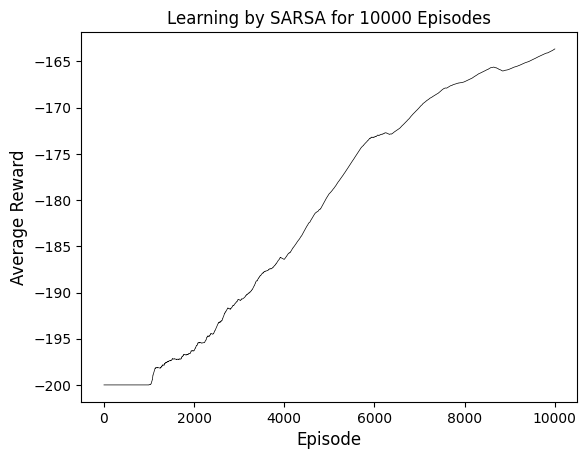

Time taken for 16 bins: 106.0050790309906


Training Progress:  10%|█         | 1006/10000 [00:13<02:53, 51.83it/s]

Now at Episode 1000. Epsilon = 0.25


Training Progress:  20%|██        | 2006/10000 [00:25<02:01, 65.82it/s]

Now at Episode 2000. Epsilon = 0.125


Training Progress:  30%|███       | 3010/10000 [00:37<01:16, 91.74it/s]

Now at Episode 3000. Epsilon = 0.0625


Training Progress:  40%|████      | 4012/10000 [00:49<00:55, 107.45it/s]

Now at Episode 4000. Epsilon = 0.03125


Training Progress:  50%|█████     | 5013/10000 [01:01<00:45, 109.33it/s]

Now at Episode 5000. Epsilon = 0.015625


Training Progress:  60%|██████    | 6013/10000 [01:11<00:55, 71.94it/s]

Now at Episode 6000. Epsilon = 0.0078125


Training Progress:  70%|███████   | 7021/10000 [01:22<00:27, 108.85it/s]

Now at Episode 7000. Epsilon = 0.00390625


Training Progress:  80%|████████  | 8014/10000 [01:32<00:18, 106.34it/s]

Now at Episode 8000. Epsilon = 0.001953125


Training Progress:  90%|█████████ | 9009/10000 [01:44<00:14, 69.32it/s]

Now at Episode 9000. Epsilon = 0.0009765625


Training Progress: 100%|██████████| 10000/10000 [01:53<00:00, 88.04it/s]


Now at Episode 10000. Epsilon = 0.00048828125


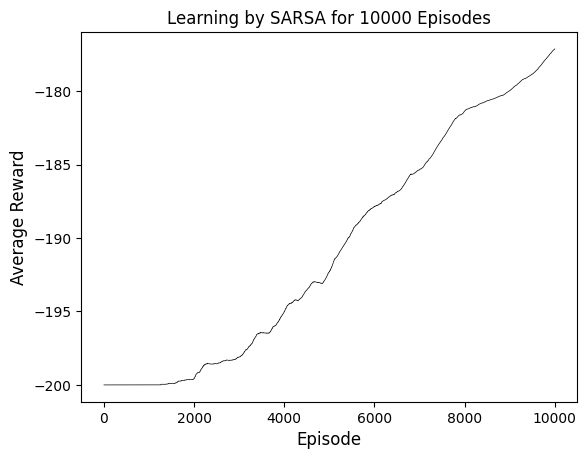

Time taken for 32 bins: 114.02874159812927


Training Progress:  10%|█         | 1004/10000 [00:16<03:39, 40.90it/s]

Now at Episode 1000. Epsilon = 0.25


Training Progress:  20%|██        | 2007/10000 [00:32<02:16, 58.36it/s]

Now at Episode 2000. Epsilon = 0.125


Training Progress:  30%|███       | 3008/10000 [00:46<02:18, 50.31it/s]

Now at Episode 3000. Epsilon = 0.0625


Training Progress:  40%|████      | 4009/10000 [00:59<01:09, 86.02it/s]

Now at Episode 4000. Epsilon = 0.03125


Training Progress:  50%|█████     | 5009/10000 [01:12<00:56, 88.24it/s]

Now at Episode 5000. Epsilon = 0.015625


Training Progress:  60%|██████    | 6004/10000 [01:26<00:41, 96.08it/s]

Now at Episode 6000. Epsilon = 0.0078125


Training Progress:  70%|███████   | 7016/10000 [01:39<00:32, 93.04it/s]

Now at Episode 7000. Epsilon = 0.00390625


Training Progress:  80%|████████  | 8015/10000 [01:52<00:23, 85.93it/s]

Now at Episode 8000. Epsilon = 0.001953125


Training Progress:  90%|█████████ | 9007/10000 [02:04<00:16, 60.07it/s]

Now at Episode 9000. Epsilon = 0.0009765625


Training Progress: 100%|██████████| 10000/10000 [02:16<00:00, 73.24it/s]


Now at Episode 10000. Epsilon = 0.00048828125


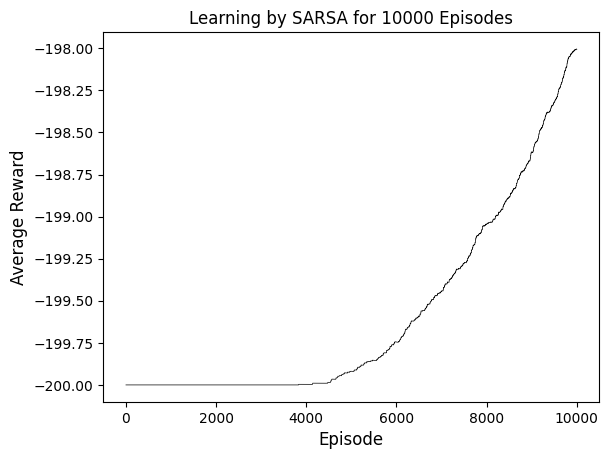

Time taken for 64 bins: 136.83643794059753


In [ ]:
# Initialize the environment
env = gym.make('MountainCar-v0')

# Initialize storage
Q_sarsa_dict = {}


# Parameters
episodes = 10000
alpha = 0.1
gamma = 0.99
epsilon = 0.5

# Record parameters
Q_sarsa_dict['params'] = {'alpha': alpha,
              'gamma': gamma,
              'epsilon': epsilon,
              'episodes': episodes,
            }


for bins in [2, 4, 8, 16, 32, 64]:
    start_time = time()
    Q_sarsa, avg_reward_array = sarsa(env, episodes, alpha, gamma, epsilon, bins)
    end_time = time()

    print(f"Time taken for {bins} bins: {end_time - start_time}")
    Q_sarsa_dict[bins] = {'Q_table': Q_sarsa,
                       'training_duration': end_time - start_time,
                       'training_rewards': avg_reward_array,
                       }





with open('Q_SARSA_mountain_car_v0.pkl', 'wb') as f:
    pickle.dump(Q_sarsa_dict, f)

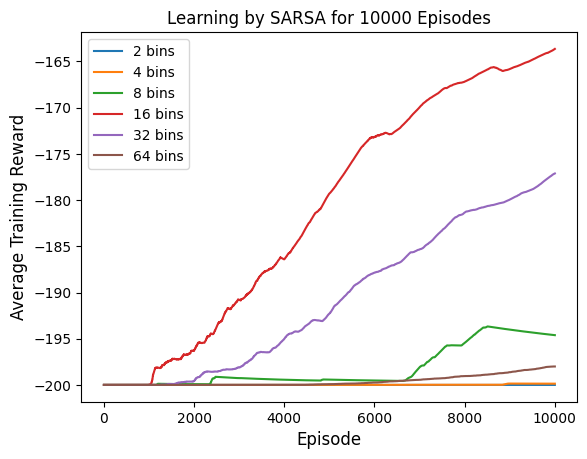

In [ ]:
# Plot training rewards vs episode index for each bins number
for bins in [2, 4, 8, 16, 32, 64]:
    plt.plot([k+1 for k in range(episodes)], Q_sarsa_dict[bins]['training_rewards'], label=f'{bins} bins')
plt.ylabel('Average Training Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.title(f'Learning by SARSA for {episodes} Episodes', fontsize=12)
plt.legend()
plt.savefig('./Q_SARSA_mountain_car_v0_avg_training_reward_vs_episode.png')
plt.show()

### Evaluation

In [ ]:
with open('Q_SARSA_mountain_car_v0.pkl', 'rb') as f:
    Q_sarsa_dict = pickle.load(f)

bins = 16
env = gym.make('MountainCar-v0')


mean_reward, std_reward = evaluate_policy(env, Q_sarsa_dict[bins]['Q_table'], bins, n_episodes=100)


Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 153.13it/s]

Average reward over 50000 episodes: -143.47


Evaluation Progress: 100%|██████████| 100/100 [00:01<00:00, 70.89it/s]


Average reward over 10000 episodes: -200.0


Evaluation Progress: 100%|██████████| 100/100 [00:01<00:00, 71.22it/s]


Average reward over 10000 episodes: -200.0


Evaluation Progress: 100%|██████████| 100/100 [00:01<00:00, 65.34it/s]


Average reward over 10000 episodes: -200.0


Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 136.26it/s]


Average reward over 10000 episodes: -141.36


Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 119.37it/s]


Average reward over 10000 episodes: -168.56


Evaluation Progress: 100%|██████████| 100/100 [00:00<00:00, 100.25it/s]


Average reward over 10000 episodes: -197.72


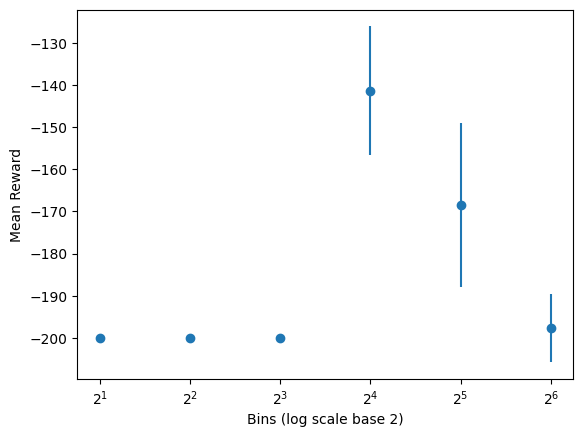

In [ ]:
# Evaluate for each bins
# Store mean and std of rewards
mean_reward_list = []
std_reward_list = []

for bins in [2, 4, 8, 16, 32, 64]:
    mean_reward, std_reward = evaluate_policy(env, Q_sarsa_dict[bins]['Q_table'], bins, n_episodes=100)
    mean_reward_list.append(mean_reward)
    std_reward_list.append(std_reward)

# Plot mean reward with std vs bins
plt.errorbar([2, 4, 8, 16, 32, 64], mean_reward_list, yerr=std_reward_list, fmt='o')
plt.xscale('log', base=2)
plt.xlabel('Bins (log scale base 2)')
plt.ylabel('Mean Reward')
# plt.title('Error Bar Plot with Log Scale X-axis')
plt.show()

### Policy Visualization

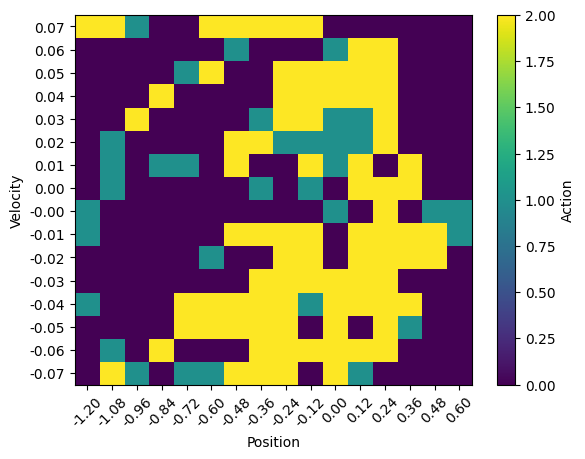

In [ ]:
plot_policy_for_tabular_q_for_mountain_car(env, bins=16, Q=Q_sarsa_dict[16]['Q_table'])

# Conclusion

1. The space complexity of state discretization is $O(b^{|S|})$, which increases exponentially with the state space dimension.
2. With fixed number of training episodes, both too coarse of discretization (bins=2, 4, 8) and too fine of discretization (bins=32, 64) result in poor performance. The reasons are different: too coarse of discretization cannot represent actual states accurately, while too fine of discretization requires more training episodes to visit all possible state-action pairs in Q-table.
2. The more bins in discretization, the better the accuracy in each bin to actual states, at the cost of requiring more training episodes and space storage, i.e., higher time and space complexity.
3. To avoid the time and space complexity induced by discretization, we need Q-function approximations which will be covered in the next tutorial.  
